In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
if ('0.11' in sns.__version__) or ('0.12' in sns.__version__):
    sns.set_theme()
else:
    sns.set()
import sys
!{sys.executable} -m pip install textblob
import textblob

In [2]:
#https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset
tweets = pd.read_csv("Tweets.csv")
tweets.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [3]:
#https://www.ncei.noaa.gov/cdo-web/datasets
climate = pd.read_csv("GHCND_sample_csv.csv")
print(climate.shape)

(31, 9)


In [4]:
#https://ia600501.us.archive.org/view_archive.php?archive=/32/items/twitter_cikm_2010/twitter_cikm_2010.zip&file=training_set_users.txt
training_users = pd.read_csv("training_set_users.txt", sep="\t", header=None, names=["UserID","UserLocation"])
training_users.head()


UserID       UserLocation
0        14      San Francisco
1        15      San Francisco
2        18  San Francisco, CA
3  19922973        Chicago, IL
4  63963170           New York

In [5]:
#https://ia600501.us.archive.org/view_archive.php?archive=/32/items/twitter_cikm_2010/twitter_cikm_2010.zip&file=training_set_tweets.txt
training_tweets = pd.read_csv("training_set_tweets.txt", sep="\t", header=None, names=["UserID","TweetID","Tweet","CreatedAt"])
training_tweets = training_tweets[training_tweets["UserID"].str.isnumeric() == True]
training_tweets["UserID"] = training_tweets["UserID"].astype("int")
print(training_tweets.shape)

training_tweets_1 = pd.read_csv("training_set_tweets_1.txt", sep="\t", header=None, names=["UserID","TweetID","Tweet","CreatedAt"], on_bad_lines='skip')
training_tweets_1 = training_tweets_1[training_tweets_1["UserID"].str.isnumeric() == True]
training_tweets_1["UserID"] = training_tweets_1["UserID"].astype("int")
print(training_tweets_1.shape)

(864, 4)
(16639, 4)


In [6]:
t_user_tweets = training_users.merge(training_tweets_1, on="UserID", how="left")

pol = pd.read_excel("cbsafactbook2021.xlsx", header=2)[:579][["Core Based Statistical Area (CBSA)", "2010 Population", "CO           8-hr (ppm)", "NO2      AM (ppb)", "NO2          1-hr (ppb)", "SO2         1-hr (ppb)"]]
pol = pol.rename(columns={'Core Based Statistical Area (CBSA)': 'City, State', 'CO           8-hr (ppm)': 'CO2 Mean', "NO2      AM (ppb)":"NO2 AM Mean", "NO2          1-hr (ppb)":"NO2 1-hr Mean","SO2         1-hr (ppb)": "SO2 Mean"})
pol = pol.replace("ND", np.nan)
pol = pol.replace("IN", np.nan)
city = r'^([^,]*)'
state = r',\s*([^,]*)'
pol["City"] = pol["City, State"].str.extract(city)
pol["State"] = pol["City, State"].str.extract(state)
pol = pol.groupby("City")[["CO2 Mean", "NO2 AM Mean", "NO2 1-hr Mean", "SO2 Mean"]].mean()
pol
#pol = pd.read_csv("uspollution_pollution_us_2000_2016.csv", usecols = ["City", "Date Local", "NO2 Mean", "SO2 Mean", "CO Mean"])
#pol = pol[pol["Date Local"].str.contains("2016")]
#t_user_tweets.head()
#pol = pol.groupby("City")[["NO2 Mean", "SO2 Mean", "CO Mean"]].mean()
#print(pol)

CO2 Mean  NO2 AM Mean  NO2 1-hr Mean  SO2 Mean
City                                                                      
Aberdeen                         NaN          NaN            NaN       NaN
Adjuntas                         NaN          NaN            NaN       NaN
Adrian                           NaN          NaN            NaN       NaN
Aguadilla-Isabela                NaN          NaN            NaN       NaN
Akron                            NaN          NaN            NaN       5.0
...                              ...          ...            ...       ...
Yakima                           NaN          NaN            NaN       NaN
York-Hanover                     NaN          8.0           40.0      15.0
Youngstown-Warren-Boardman       NaN          NaN            NaN       NaN
Yuba City                        NaN          5.0           34.0       NaN
Yuma                             NaN          NaN            NaN       NaN

[549 rows x 4 columns]

In [7]:
t_user_tweets["Sentiment"] = t_user_tweets["Tweet"].astype(str).apply(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)
city = r'^([^,]*)'
state = r',\s*([^,]*)'
t_user_tweets["City"] = t_user_tweets["UserLocation"].str.extract(city)
t_user_tweets["State"] = t_user_tweets["UserLocation"].str.extract(state)
print(t_user_tweets.shape)
t_user_tweets.dropna(subset=['Tweet'], inplace=True)
tweets = pd.merge(t_user_tweets, pol, on = "City", how = "left")
tweets.head()

(133802, 8)


UserID   UserLocation     TweetID  \
0      14  San Francisco  1567978127   
1      14  San Francisco  1551907112   
2      14  San Francisco  1539281043   
3      14  San Francisco  1513711531   
4      14  San Francisco  1455281562   

                                               Tweet            CreatedAt  \
0  The flock of bees splatter the windshield like...  2009-04-20 14:09:20   
1  Watching him on TV, I wondered how I became so...  2009-04-18 12:16:56   
2  My inner dirthead child limps a  smile at the ...  2009-04-16 22:30:57   
3  Riding this blue steel dog Down thru the atmos...  2009-04-13 21:14:58   
4  Driving this blue steel dog, pregnant and lumb...  2009-04-04 22:48:26   

   Sentiment           City State  CO2 Mean  NO2 AM Mean  NO2 1-hr Mean  \
0   0.000000  San Francisco   NaN       NaN          NaN            NaN   
1   0.000000  San Francisco   NaN       NaN          NaN            NaN   
2   0.008333  San Francisco   NaN       NaN          NaN            NaN   
3   0.073611  San Francisco   NaN       NaN          NaN            NaN   
4   0.166667  San Francisco   NaN       NaN          NaN            NaN   

   SO2 Mean  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [8]:
import matplotlib.pyplot as plt
plot = tweets.groupby("City")[["Sentiment", "SO2 Mean"]].mean().sort_values("SO2 Mean")


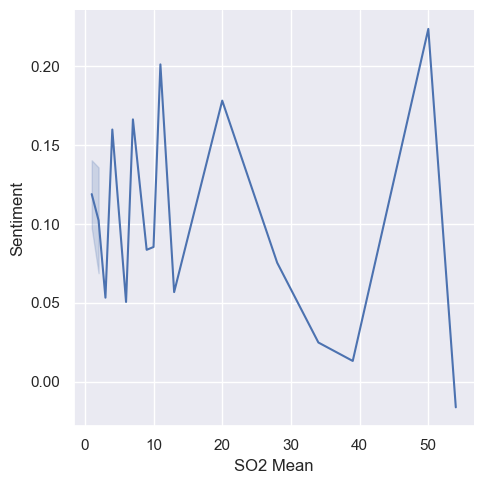

In [9]:
sns.relplot(x = "SO2 Mean", y = "Sentiment", data = plot, kind = "line")
plt.show()

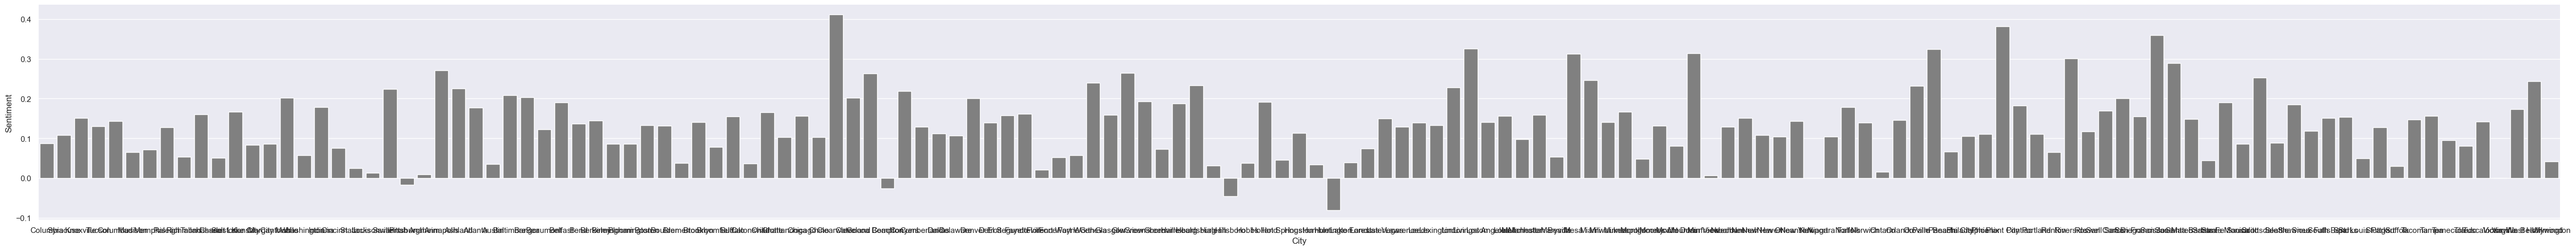

In [10]:
plot1 = tweets.groupby("City", as_index=False)[["Sentiment", "SO2 Mean"]].mean().sort_values("SO2 Mean")
sns.catplot(x="City", y = "Sentiment", data = plot1, kind = "bar", 
            color="gray", aspect=10)
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn import preprocessing

adj_plot = plot.dropna()
#print(adj_plot)

#which direction tho?
#data_senti = adj_plot[["Sentiment"]].values
#target_senti = adj_plot[["SO2 Mean"]].values

target_senti = adj_plot[["Sentiment"]].values
data_senti = adj_plot[["SO2 Mean"]].values


#split data 70%<-training 30%<-test?
train_data, test_data, train_target, test_target = train_test_split(
    data_senti, target_senti, test_size=0.7, random_state=216)

linear_model = LinearRegression()
linear_model.fit(X=train_data,y=train_target)
predicted_so2 = linear_model.predict(train_data)

mse1 = mean_squared_error(train_target, predicted_so2)
r2_1 = r2_score(train_target, predicted_so2)

print("Linear Model Training MSE: ", mse1)
print("Linear Model Training r2: ", r2_1)

########

test_predicted_so2 = linear_model.predict(test_data)
score2 = linear_model.score(test_data, test_target)
#display2 = ConfusionMatrixDisplay.from_estimator(linear_model, test_data, test_target)

print("Linear model test classification accuracy:", score2)

####
#only takes discrete input
lab = preprocessing.LabelEncoder()
train_target, test_target = lab.fit_transform(train_target), lab.fit_transform(test_target) 

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X=train_data,y=train_target)
predicted_so3 = linear_model.predict(train_data)

mse3 = mean_squared_error(train_target, predicted_so3)
r2_3 = r2_score(train_target, predicted_so3)

print("Logistic Model Training MSE: ", mse3)
print("Logistic Model Training r2: ", r2_3)

########

test_predicted_so4 = linear_model.predict(test_data)
score4 = logistic_model.score(test_data, test_target)
print("Logistic model test classification accuracy:", score4)

display2 = ConfusionMatrixDisplay.from_estimator(logistic_model, test_data, test_target)
plt.grid(False)
plt.show()

Linear Model Training MSE:  0.0029813574283281082
Linear Model Training r2:  0.07654708657631248
Linear model test classification accuracy: -0.0004884418172250715
Logistic Model Training MSE:  8.67469083171932
Logistic Model Training r2:  -1.974179713732338
Logistic model test classification accuracy: 0.0625


C:\Users\etesh\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\etesh\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
